# Model evaluation

## Importing

In [6]:
import json
from google_drive_downloader import GoogleDriveDownloader as gdd
import shutil, os
from ops import load_opt, load_sar, generate_save_patches, min_max_scaler
import numpy as np
import logging
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle
import numpy as np
import skimage.morphology
from sklearn.metrics import confusion_matrix
from model.models import Model_1
from model.losses import FocalLoss, WBCE
from tensorflow.keras.layers import Input
from dataloader import DataLoader
from tensorflow.keras.optimizers.schedules import InverseTimeDecay



## Load Model

In [7]:
# load the params-patches.json options
with open(os.path.join('v1', 'params-patches.json')) as param_file:
    params_patches = json.load(param_file)

# load the params-patches.json options
with open(os.path.join('v1', 'params-training.json')) as param_file:
    params_training = json.load(param_file)
    
#load the params-model.json options
with open(os.path.join('v1', 'params-model.json')) as param_file:
    params_model = json.load(param_file)

#load the shapes.json options
with open('shapes.json') as param_file:
    shapes_json = json.load(param_file)

In [8]:
patches_path = params_patches['patches_path']

train_path = os.path.join(patches_path, params_patches['train_sub'])
val_path = os.path.join(patches_path, params_patches['val_sub'])
test_path = os.path.join(patches_path, params_patches['test_sub'])
full_path = params_patches['full_path']

img_path = params_patches['img_path']
data_raw = os.path.join(img_path, params_patches['data_sub']) 
label_raw = os.path.join(img_path, params_patches['label_sub'])


In [9]:
model = Model_1(name='modelo_1')

metrics = {
}

weights = [0.2, 0.8, 0.0]


optimizers = {
    'opt': tf.keras.optimizers.Adam(learning_rate = 1e-4),
    'sar': tf.keras.optimizers.Adam(learning_rate = 1e-4),
    'fusion': tf.keras.optimizers.Adam(learning_rate = 1e-4),
}

class_indexes = [0, 1]

model.compile(
    optimizers = optimizers,
    loss_fn = WBCE,
    metrics_dict = metrics,
    class_weights = weights,
    class_indexes = class_indexes,
    run_eagerly=params_training['run_eagerly']
)

model.build(
    input_shape = [
        (None, params_patches['patch_size'], params_patches['patch_size'], params_model['opt_channels']),
        (None, params_patches['patch_size'], params_patches['patch_size'], params_model['sar_channels'])
    ]
    )
model.load_weights('weights.h5')

## Eval Model

### Load images

In [10]:
opt = np.load(os.path.join(data_raw, 'opt.npy'))
sar = np.load(os.path.join(data_raw, 'sar.npy'))

### Make Predictions

In [11]:
pred = model.predict_from_patches(
    (opt, sar), 
    params_patches['patch_size'], 
    params_patches['patch_stride'], 
    16)

  0%|          | 0/9990 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



  4%|▍         | 389/9990 [00:35<13:04, 12.23it/s]

In [ ]:
labels = np.load(os.path.join(label_raw, 'labels.npy'))

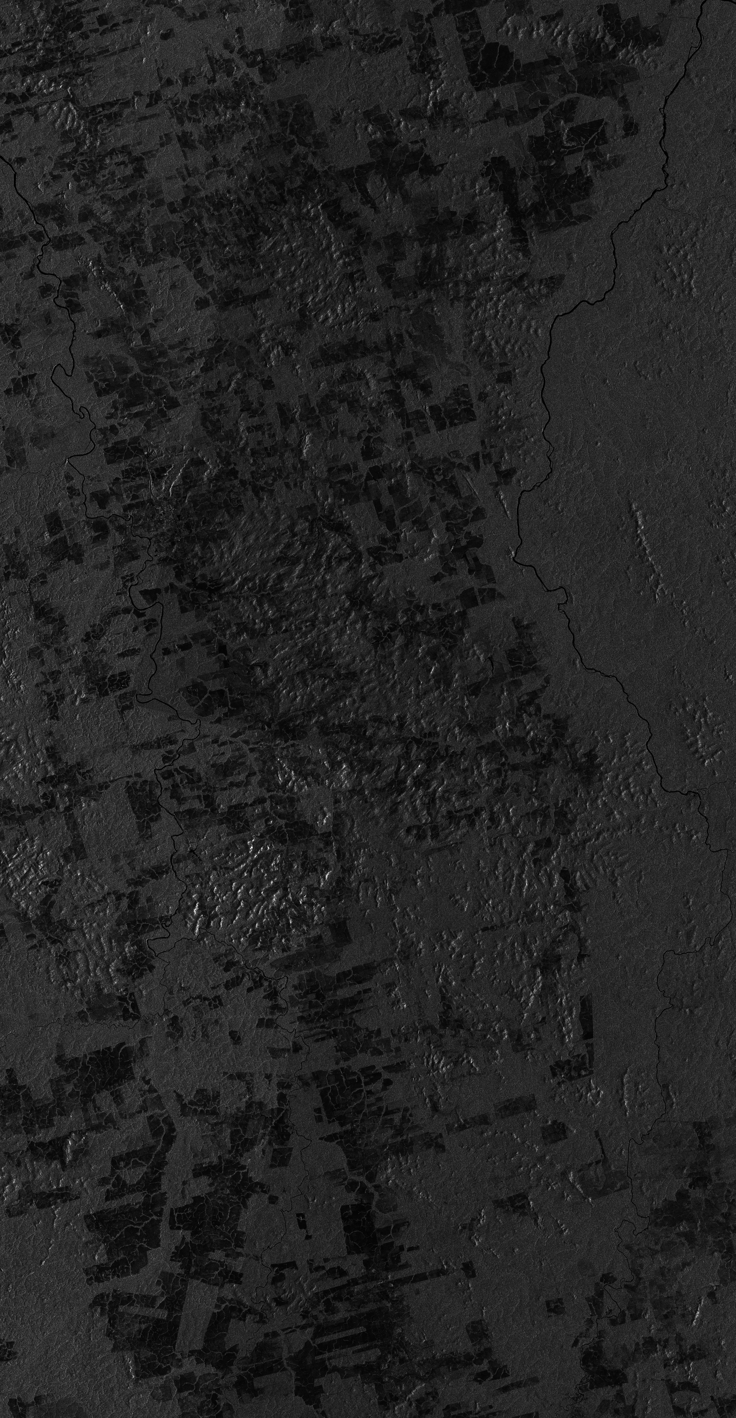

In [9]:
img = Image.fromarray(np.uint8(sar[:, :, 0]*255))
resize = 0.08
shape = (int(resize*sar.shape[1]), int(resize*sar.shape[0]))
img.resize(shape)

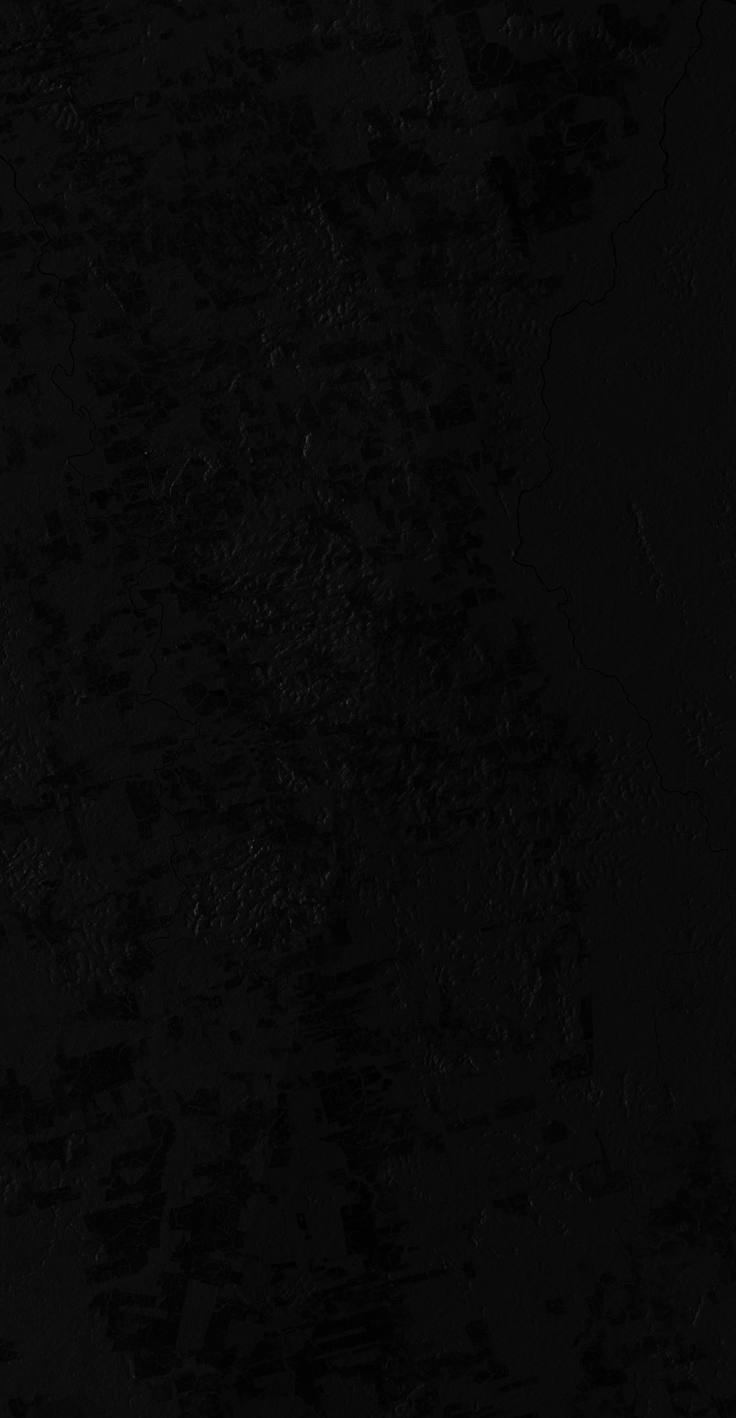

In [10]:
img = Image.fromarray(np.uint8(pred[0][:, :, 0]*255))
resize = 0.08
shape = (int(resize*pred.shape[1]), int(resize*pred.shape[0]))
img.resize(shape)